En el archivo credits se encuentran datos sobre el elenco y el equipo técnico de varias películas, representados en un formato de lista de diccionarios. Estos datos contienen detalles sobre los actores, directores, guionistas, productores, y otros miembros del equipo técnico involucrados en las películas. Visualmente tenemos 3 columnas cast  ,crew, id. Procedemos a realizar la extracción de sus columnas y datos.

In [18]:
import pandas as pd
import ast
import json
import numpy as np
import os

In [28]:
# Cargamos el archivo credits.csv en un DataFrame
credits = pd.read_csv('C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits.csv')

# Normalizamos los nombres de las columnas para que no que de espacios entre los nombres
credits.columns = credits.columns.str.strip()

# Reemplazamos NaN por strings vacíos en las columnas 'cast' y 'crew'
credits['cast'] = credits['cast'].fillna('')
credits['crew'] = credits['crew'].fillna('')

# Función para evaluar los valores de la columna y convertir a lista de diccionarios
def evaluacion(value):
    if isinstance(value, list):
        return value
    if value == '':
        return []
    try:
        return ast.literal_eval(value)
    except (SyntaxError, ValueError):
        try:
            return json.loads(value)
        except (json.JSONDecodeError, TypeError) as e:
            print(f"Error al evaluar: {value} -> {e}")
            return []

# Aplicamos la función a las columnas 'cast' y 'crew'
credits['cast'] = credits['cast'].apply(evaluate_value)
credits['crew'] = credits['crew'].apply(evaluate_value)
"""
En este paso usaremos explode para separar las listas en filas separadas, pd.json_normalize para extraer 
la información seleccionada de cada lista y pd.concat para concatenar las columnas resultantes .

De la columna crew consideró solo relevante los nombres de los directores ya que los demás datos son del personal
 menos relevante de producción 


"""
# Desanidamops la columna 'cast'
credits_cast = credits[['id', 'cast']].explode('cast').reset_index(drop=True)
cast_df = pd.json_normalize(credits_cast['cast'])
cast_df['id'] = credits_cast['id']

# Extraemos el dato de los nomres de los directore delas peliculas  de 'crew' para cada película
def extract_directors(crew_list):
    return [member['name'] for member in crew_list if member.get('job') == 'Director']

# Creamos una nueva columna en credits solo con los nombres de los directores
credits['directors'] = credits['crew'].apply(extract_directors)

# Convertimos la columna 'directors' en un DataFrame y hacer merge con el DataFrame 'cast_df'
directors_df = credits[['id', 'directors']].explode('directors').dropna()
final_df = cast_df.merge(directors_df, on='id', how='left')

# Guardamos el resultado final en un archivo CSV
output_file = 'C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits_desanidado.csv'
final_df.to_csv(output_file, index=False)


print("\nDataFrame desanidado (con nombres de directores añadidos):")
print(final_df.head())





DataFrame desanidado (con nombres de directores añadidos):
   cast_id                character                 credit_id  gender   id  \
0     14.0            Woody (voice)  52fe4284c3a36847f8024f95     2.0  862   
1     15.0   Buzz Lightyear (voice)  52fe4284c3a36847f8024f99     2.0  862   
2     16.0  Mr. Potato Head (voice)  52fe4284c3a36847f8024f9d     2.0  862   
3     17.0       Slinky Dog (voice)  52fe4284c3a36847f8024fa1     2.0  862   
4     18.0              Rex (voice)  52fe4284c3a36847f8024fa5     2.0  862   

            name  order                      profile_path      directors  
0      Tom Hanks    0.0  /pQFoyx7rp09CJTAb932F2g8Nlho.jpg  John Lasseter  
1      Tim Allen    1.0  /uX2xVf6pMmPepxnvFWyBtjexzgY.jpg  John Lasseter  
2    Don Rickles    2.0  /h5BcaDMPRVLHLDzbQavec4xfSdt.jpg  John Lasseter  
3     Jim Varney    3.0  /eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg  John Lasseter  
4  Wallace Shawn    4.0  /oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg  John Lasseter  


Al desanidar nos topamos con algunas columnas que no considero relevantes por eso las borramos 

In [29]:

# Cargamos el archivo credits.csv en un DataFrame
credits = pd.read_csv('C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits_desanidado.csv')

# Borramos las columnas al considerarlas de poca relevancia: 'cast_id', 'character', 'credit_id', 'gender', 'profile_path'
cast_df = cast_df.drop(columns=['cast_id', 'character', 'credit_id', 'gender', 'profile_path'])

# Filtramos las filas donde la columna 'order' tenga los valores 0 para actor principal y 1 para actor secundario
cast_df_filtered = cast_df[cast_df['order'].isin([0, 1])]

# Hacemos merge para incluir los directores en el DataFrame filtrado de cast
final_df = cast_df_filtered.merge(directors_df, on='id', how='left')

# Guardamos el resultado final en un archivo CSV
output_file = 'C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits_desanidado.csv'
final_df.to_csv(output_file, index=False)

print(f"\nDataFrame filtrado guardado en el archivo: {output_file}")



DataFrame filtrado guardado en el archivo: C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits_desanidado.csv


Para una mejor comprención cambiamos los nombres a español y remplasamos  por principal  y 0 por secundario

In [30]:
import pandas as pd

# Cargamos el archivo desanidado
cast_df_filtered = pd.read_csv('C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits_desanidado.csv')

# Renombramos  las columnas
cast_df_filtered.rename(columns={
    'id': 'id_pelicula',
    'name': 'nombre_actor',
    'order': 'papel',
    'directors': 'director'
}, inplace=True)

# Cambiamos los valores de la columna 'papel' para asignar roles em la pelicula
cast_df_filtered['papel'] = cast_df_filtered['papel'].replace({0: 'Principal', 1: 'Secundario'})

# Guardamos el DataFrame actualizado en el archivo CSV
cast_df_filtered.to_csv('C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits_desanidado.csv', index=False)

print("Archivo actualizado y guardado exitosamente con las columnas renombradas al español.")




Archivo actualizado y guardado exitosamente con las columnas renombradas al español.


Procedemos a hacer un resumen estadístico del data frame resultante en el cual obtendremos las dimensiones ,el tipo de dato y valores faltantes por columna.

In [31]:
file_path = 'C:/Users/jrgsi/OneDrive/Escritorio/PROUECTOS HENRY/SISTEMA DE RECOMENDACION PELICULAS/datos/credits_desanidado.csv'

df = pd.read_csv(file_path)

df.head()

print(f"Dimenciones del dataframe :´{df.shape}")

df.info()

print("Valores nulos por columna")
print(df.isnull().sum())

missing_values = df.isnull().mean()*100
print ("Porsentaje de valores faltantes por columna:\n",missing_values)

Dimenciones del dataframe :´(85550, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85550 entries, 0 to 85549
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_pelicula   85550 non-null  int64 
 1   nombre_actor  85550 non-null  object
 2   papel         85550 non-null  object
 3   director      84891 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.6+ MB
Valores nulos por columna
id_pelicula       0
nombre_actor      0
papel             0
director        659
dtype: int64
Porsentaje de valores faltantes por columna:
 id_pelicula     0.00000
nombre_actor    0.00000
papel           0.00000
director        0.77031
dtype: float64


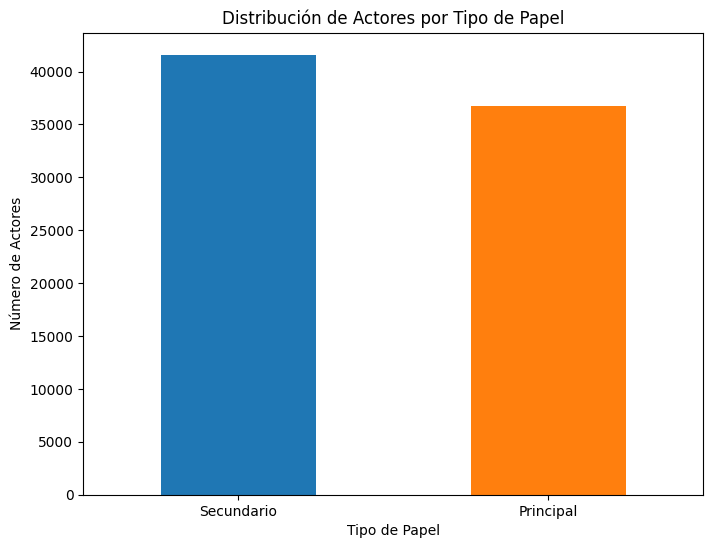

In [6]:
import matplotlib.pyplot as plt

# Crear un gráfico de barras para la distribución de actores principales y secundarios
papel_counts = cast_df_filtered['papel'].value_counts()

plt.figure(figsize=(8, 6))
papel_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribución de Actores por Tipo de Papel')
plt.xlabel('Tipo de Papel')
plt.ylabel('Número de Actores')
plt.xticks(rotation=0)
plt.show()


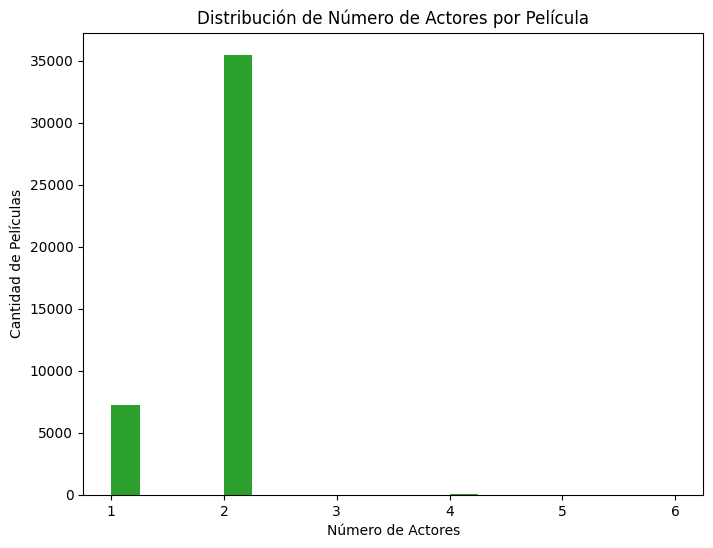

In [7]:
# Crear un gráfico de histograma para la cantidad de actores por película
actores_por_pelicula = cast_df_filtered.groupby('id_pelicula')['nombre_actor'].count()

plt.figure(figsize=(8, 6))
plt.hist(actores_por_pelicula, bins=20, color='#2ca02c')
plt.title('Distribución de Número de Actores por Película')
plt.xlabel('Número de Actores')
plt.ylabel('Cantidad de Películas')
plt.show()
